In [1]:
########################################################################################################
################################ Preparing Data for Bogotá city  #######################################
########################################################################################################

# Autor: Juan Henao, Estudiante Ing. Electrónica. 
# Trabajo de Grado. 
# Última fecha de revisión 10/11/2021
# Presentado a: Ing. Catalina Alvarado 
#               D.A. Germán González 

import pandas as pd
import geopandas as gpd
import datetime as dt
import numpy as np
import json
import matplotlib.pyplot as plt

from unicodedata import normalize

#Excel file with Bogotá localities, id, latitude and longitude  
path = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Files/Localidades_Nombres.xlsx"
Bog = pd.read_excel(path, sheet_name='Hoja1')

# Bogota info DF provided by local Town Hall
path = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Files/georeferencia-puntual-por-localidad.csv"
geoBog = pd.read_csv(path, encoding = 'UTF-8',  sep='\t', delimiter=";")
geoBog = geoBog.sort_values(by='CODIGO', ascending=True)

# CSV containing confirmed Covid-19 cases in Bogotá sorted by localities 
# a locality is a big region in Bogotá city. Inside every locality there are several neighbourhoods
path = "/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Files/casos_confirmados_Bog.csv"
CovidBog = pd.read_csv(path, encoding = "UTF-8", sep='\t', delimiter=";", low_memory=False)

del path

In [2]:
#Reported  cases file head
CovidBog.head(5)

,CASO,FECHA_DE_INICIO_DE_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_DE_CONTAGIO,UBICACION,ESTADO
0,1,2020-02-26,2020-03-06,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,2,2020-03-04,2020-03-10,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,3,2020-03-07,2020-03-10,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,4,2020-03-06,2020-03-12,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,5,2020-03-06,2020-03-12,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


In [3]:
# In CovidBog DF
# Drop Cols we don´t need
CovidBog = CovidBog.drop(columns=['EDAD', 'FUENTE_O_TIPO_DE_CONTAGIO', 'UBICACION', 'ESTADO', 'CIUDAD', 'UNI_MED', 'SEXO', 'CASO' ])

# add some cols in order to write in them needed data 
CovidBog['CODIGO_LOCALIDAD'] = 0 

# Re-order cols 
CovidBog = CovidBog.reindex(columns=['FECHA_DE_INICIO_DE_SINTOMAS', 'FECHA_DIAGNOSTICO', 'LOCALIDAD_ASIS', 'CODIGO_LOCALIDAD'])

# Delete rows with missing values 
CovidBog = CovidBog.dropna(axis=0, how='any', subset=['FECHA_DIAGNOSTICO'])

In [4]:
#changing all locality strings to lower_case and taking off accents
trans_tab = dict.fromkeys(map(ord, u'\u0301\u0308'), None)

#Bog DF
Bog['Localidad'] = Bog.apply(lambda row: row['Localidad'].lower(), axis=1)
Bog['Localidad'] = Bog.apply(lambda row: normalize('NFKC', normalize('NFKD', row['Localidad']).translate(trans_tab)), axis=1)

#geoBog DF
geoBog['LOCALIDAD'] = geoBog.apply(lambda row: row['LOCALIDAD'].lower(), axis=1)
geoBog['LOCALIDAD'] = geoBog.apply(lambda row: normalize('NFKC', normalize('NFKD', row['LOCALIDAD']).translate(trans_tab)), axis=1)

#CovidBog DF
CovidBog['LOCALIDAD_ASIS'] = CovidBog.apply(lambda row: row['LOCALIDAD_ASIS'].lower(), axis=1)
CovidBog['LOCALIDAD_ASIS'] = CovidBog.apply(lambda row: normalize('NFKC', normalize('NFKD', row['LOCALIDAD_ASIS']).translate(trans_tab)), axis=1)

#delete vars no longer used 
del trans_tab

In [5]:
#Equal FECHA_DE_INICIO_DE_SINTOMAS to FECHA_DIAGNOSTICO when FECHA_DE_INICIO_DE_SINTOMAS = NaN
#Detect NaN Sympthoms date
CovidBog['AUX'] = CovidBog['FECHA_DE_INICIO_DE_SINTOMAS'].isna() 

#Change NaN Dates by diagnosis date. 
#CovidBog['FECHA_DE_INICIO_DE_SINTOMAS'] = CovidBog.apply(lambda row: row['FECHA_DIAGNOSTICO'] if row['FECHA_DE_INICIO_DE_SINTOMAS'].isna() == True else row['FECHA_DE_INICIO_DE_SINTOMAS'], axis=1)
CovidBog['FECHA_DE_INICIO_DE_SINTOMAS'] = CovidBog.apply(lambda row: row['FECHA_DIAGNOSTICO'] if row['AUX'] == True else row['FECHA_DE_INICIO_DE_SINTOMAS'], axis=1)
CovidBog = CovidBog.drop(columns=['AUX'])

In [6]:
#############################################################################################################
########### Declare variables and lists used in code to asign/calculate localities, latitude, longitude #####
#############################################################################################################

#Localities name list 
Loc_hist_names = list(Bog['Localidad'])

#Localities historical count init 
Loc_hist = [0]*len(Loc_hist_names)

#Local id code list
Loc_codes = list(range(len(Loc_hist_names)))

#Localities latitude 
Loc_Lat = list(geoBog['LONGITUD'])
Loc_Lat[0] = 'NoLat'
Loc_Lat.append('NoLat')

#Localities Longitude
Loc_Long = list(geoBog['LATITUD'])
Loc_Long[0] = 'NoLong'
Loc_Long.append('NoLong')


In [7]:
# Change str Dates to Datetime objects
CovidBog['FECHA_DIAGNOSTICO'] = pd.to_datetime(CovidBog['FECHA_DIAGNOSTICO'], format='%Y/%m/%d')
CovidBog['FECHA_DE_INICIO_DE_SINTOMAS'] = pd.to_datetime(CovidBog['FECHA_DE_INICIO_DE_SINTOMAS'], format='%Y/%m/%d')

#Re organize rows by ascending datetime object
CovidBog = CovidBog.sort_values(by='FECHA_DE_INICIO_DE_SINTOMAS', ascending=True)
CovidBog = CovidBog.reset_index(drop=True)

In [8]:
################################################################################################
############################# defining functions used later in code ############################
################################################################################################

#######################################################################
################ method used to count historical cases ################
#######################################################################
def hist_count(localidad):
    for i in range(len(Loc_hist_names)):
        if localidad == Loc_hist_names[i]:
            Loc_hist[i] += 1
            return Loc_hist[i]

#############################################################################
################## method used for filling local ID code ####################
#############################################################################
def local_ID (localidad):
    for i in range(len(Loc_hist_names)):
        if localidad == Loc_hist_names[i]:
            return Loc_codes[i]
        
#############################################################################
############ method used for asigning latitud to every locality #############
#############################################################################
def local_Lat (localidad):
    for i in range(len(Loc_hist_names)):
        if localidad == Loc_hist_names[i]:
            return Loc_Lat[i]
        
###############################################################################
############ method used for asigning longitude to every locality #############
###############################################################################
def local_Long (localidad):
    for i in range(len(Loc_hist_names)):
        if localidad == Loc_hist_names[i]:
            return Loc_Long[i]

In [9]:
#Asign local ID code 
CovidBog['CODIGO_LOCALIDAD'] = CovidBog.apply(lambda row: local_ID(row['LOCALIDAD_ASIS']), axis=1)

In [10]:
#Group historic reports by date and localities
fechas = CovidBog.groupby(['FECHA_DE_INICIO_DE_SINTOMAS', 'CODIGO_LOCALIDAD'])['LOCALIDAD_ASIS'].count()
fechas.to_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/fechas_sintomas.csv')

fechas_df = pd.read_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/fechas_sintomas.csv')
fechas_df = fechas_df.rename(columns={'LOCALIDAD_ASIS': 'CASOS_REPORTADOS'})#Rename Column

#Change str to datetime objects
fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'] = pd.to_datetime(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS'], format='%Y-%m-%d')
fechas_df = fechas_df.sort_values(by='FECHA_DE_INICIO_DE_SINTOMAS', ascending=True)
fechas_df = fechas_df.reset_index(drop=True)

#Drop 0 and 21 id codes since they don´t belong to Bogotá geography 
index_0 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 0 ].index
index_21 = fechas_df[ fechas_df['CODIGO_LOCALIDAD'] == 21 ].index

fechas_df.drop(index_0, inplace = True)#drop fuera de bogotá and sin dato rows since we cannot calculate infection 
fechas_df.drop(index_21, inplace = True)# density for them (we don´t know their reference population)
#Reset index
fechas_df = fechas_df.reset_index(drop = True)

In [11]:
#reported cases organized by localities and dates data frame head
fechas_df.head(10)

,FECHA_DE_INICIO_DE_SINTOMAS,CODIGO_LOCALIDAD,CASOS_REPORTADOS
0,2020-02-26,1,1
1,2020-02-28,13,1
2,2020-03-04,10,2
3,2020-03-04,11,1
4,2020-03-05,1,1
5,2020-03-05,2,1
6,2020-03-05,13,1
7,2020-03-06,12,1
8,2020-03-06,10,1
9,2020-03-06,9,1


In [12]:
#create grid and fill it with reported cases y axis correspond to Bogota localities id code, 
#x axis correspond to number of days passed since pandemic started 
#that way 0 index -> 2020-02-06, 1->2020-02-07 and so on

com_index = len(fechas_df['FECHA_DE_INICIO_DE_SINTOMAS']) #column length 
start_date = fechas_df.loc[0, 'FECHA_DE_INICIO_DE_SINTOMAS'] #start of the pandemic in Bogotá 
end_date = fechas_df.loc[com_index-1, 'FECHA_DE_INICIO_DE_SINTOMAS'] #Last reported date 

pan_days = end_date - start_date
pan_days = int(pan_days.days) #Days passed since pandemic started to last reported date grid x axis 
local_bog = len(Loc_hist_names) - 2 # number of rows for y axis we are not considering 0 and 21 codes 

grid = np.ndarray([local_bog, pan_days+1]) #create grid
grid.fill(0) #fill grid with 0 

#Method used to fill grid with reported cases 
def fillGrid(date, code, cases):
    col = date - start_date
    col = int(col.days)
    grid[code-1][col] = cases
    

#Fill grid with cases 
fechas_df.apply(lambda row: fillGrid(row['FECHA_DE_INICIO_DE_SINTOMAS'], row['CODIGO_LOCALIDAD'], int(row['CASOS_REPORTADOS']) ), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
11293    None
11294    None
11295    None
11296    None
11297    None
Length: 11298, dtype: object

In [13]:
#Create New DataFrame with all days report (even if there are no cases to report on certain day) 
def createReport (grid, start_date):
    fecha_sintomas = []
    codigo_loc = []
    casos = []
    for col in range(pan_days): #for each day of pandemic
        for row in range(local_bog): #for each locality, fill grid
            fecha_sintomas.append(start_date) 
            codigo_loc.append(row+1)
            casos.append(grid[row][col])
        start_date += dt.timedelta(days=1)
    DF = pd.DataFrame(list(zip(fecha_sintomas, codigo_loc, casos)), 
                      columns=['FECHA_DE_INICIO_DE_SINTOMAS', 'CODIGO_LOCALIDAD', 'CASOS_REPORTADOS'])
    
    DF['CASOS_REPORTADOS'] = pd.to_numeric(DF['CASOS_REPORTADOS'], downcast='integer')
    return DF

#Create New DataFrame 
reporte = createReport(grid, start_date)

In [14]:
# Report head
reporte.head(2)

,FECHA_DE_INICIO_DE_SINTOMAS,CODIGO_LOCALIDAD,CASOS_REPORTADOS
0,2020-02-26,1,1
1,2020-02-26,2,0


### Data Integrity plots

In [15]:
#Comparing reported cases for every month that has passed since pandemic started in Bogotá 
month_seq = pd.date_range(start_date, end_date, freq='M')
month_count = [0]*len(month_seq)

def month_report (date, reported):
    for i in range(len(month_seq)):
        if date.month == month_seq[i].month and date.year == month_seq[i].year:
            month_count[i] = month_count[i] + reported
            
reporte.apply(lambda row: month_report(row['FECHA_DE_INICIO_DE_SINTOMAS'], row['CASOS_REPORTADOS']), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
12375    None
12376    None
12377    None
12378    None
12379    None
Length: 12380, dtype: object

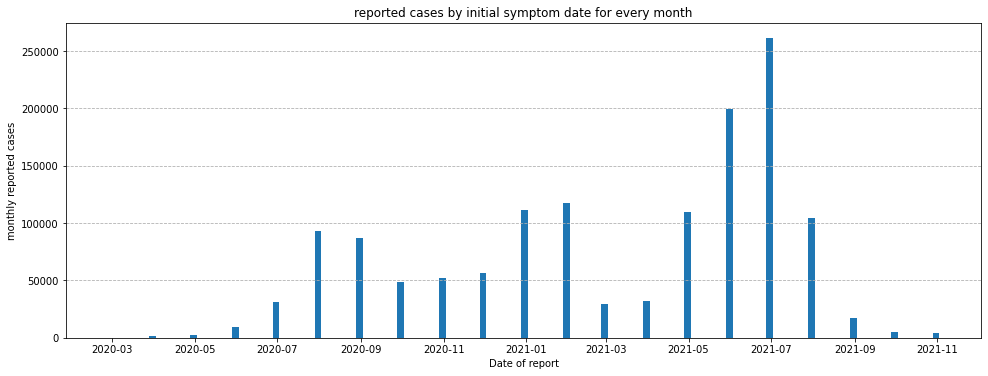

In [16]:
# Making a Bar Graph
w = 16.4
h = 5.8
plt.figure(1, figsize=[w, h])
plt.title('reported cases by initial symptom date for every month')
plt.bar(month_seq, month_count, width=5)
plt.axis('on')
plt.grid(axis='y', linestyle='--')
plt.ylabel("monthly reported cases")
plt.xlabel("Date of report")
plt.show()

## Recreating Files to use Kiamari's algorithm

In [17]:
Loc_hist = [0]*len(Loc_hist_names)
# Function that counts accumulated reported cases in each locality
def acc_count(localidad, reported):
    for i in range(len(Loc_hist_names)):
        if localidad == Loc_codes[i]:
            Loc_hist[i] += reported
            return Loc_hist[i]
        
#Count accumulated reported cases
reporte['CASOS_ACUMULADOS'] = 0
reporte['CASOS_ACUMULADOS'] = reporte.apply(lambda row: acc_count(row['CODIGO_LOCALIDAD'], row['CASOS_REPORTADOS']), axis=1)


In [18]:
# Recreate Covid-19.csv for Bog with accumulative Cases 

Covid_19_Bog = reporte.copy()

Covid_19_Bog['Latitude'] = 0
Covid_19_Bog['Longitude'] = 0
Covid_19_Bog['Region'] = 0

Covid_19_Bog['Latitude'] = Covid_19_Bog.apply(lambda row: Loc_Lat[row['CODIGO_LOCALIDAD']], axis=1)
Covid_19_Bog['Longitude'] = Covid_19_Bog.apply(lambda row: Loc_Long[row['CODIGO_LOCALIDAD']], axis=1)
Covid_19_Bog['Region'] = Covid_19_Bog.apply(lambda row: Loc_hist_names[row['CODIGO_LOCALIDAD']], axis=1)

Covid_19_Bog = Covid_19_Bog.drop(columns=['CODIGO_LOCALIDAD', 'CASOS_REPORTADOS'])
Covid_19_Bog = Covid_19_Bog.rename(columns={'FECHA_DE_INICIO_DE_SINTOMAS': 'Time Stamp', 'CASOS_ACUMULADOS': 'Number of cases'})
Covid_19_Bog = Covid_19_Bog[['Time Stamp', 'Region', 'Latitude', 'Longitude', 'Number of cases']]

Covid_19_Bog['Time Stamp'] = Covid_19_Bog['Time Stamp'].dt.strftime("%m-%d-%Y")

Covid_19_Bog.to_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Covid-19-Bog_Acc.csv', index=False)

Covid_19_Bog['Time Stamp'] = pd.to_datetime(Covid_19_Bog['Time Stamp'], format="%m-%d-%Y")

Covid_19_Bog.head(5)

,Time Stamp,Region,Latitude,Longitude,Number of cases
0,2020-02-26,usaquen,-74.0312,4.7485,1
1,2020-02-26,chapinero,-74.0467,4.6569,0
2,2020-02-26,santa fe,-74.0298,4.5963,0
3,2020-02-26,san cristobal,-74.0883,4.5463,0
4,2020-02-26,usme,-74.1033,4.4766,0


In [19]:
#Recreate lacounty_covid.json for Cumulative Cases
loc_covid = {}
last = 0
count = 0

def Bogloc_covid (dic, date, region, casos):
    global last 
    global count
    
    if last == 0: 
        last = date.day
        count = last
        dic.update({str(count):[ [region, str(casos)] ]})
        
    elif int(date.day) == last:
        dic[str(count)].append([region, str(casos)])
        
    elif int(date.day) != last:
        count += 1
        last = int(date.day)
        dic.update({str(count):[ [region, str(casos)] ]})
        
Covid_19_Bog['Time Stamp'] = pd.to_datetime(Covid_19_Bog['Time Stamp'], format="%m-%d-%Y")
Covid_19_Bog.apply(lambda row: Bogloc_covid(loc_covid, row['Time Stamp'], row['Region'], row['Number of cases']), axis=1)
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/bog_covid_Acc.json'

with open(path, 'w') as fp:
    json.dump(loc_covid, fp, sort_keys=True, ensure_ascii=False)

In [20]:
# Load Bogotá localities population file
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Files/Poblacion_Bogota.xlsx'
PobBog = pd.read_excel(path, sheet_name='1.1')
PobBog = PobBog.drop([PobBog.index[0], PobBog.index[1], PobBog.index[2], PobBog.index[3], PobBog.index[4], 
                      PobBog.index[25], PobBog.index[26]])

PobBog = PobBog.filter(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 17', 'Unnamed: 18'])
PobBog = PobBog.rename(columns={'Unnamed: 0': 'Código localidad', 'Unnamed: 1': 'localidad',
                                     'Unnamed: 17': 'Población 2020', 'Unnamed: 18': 'Población 2021'})

PobBog = PobBog.set_index(PobBog['Código localidad'])

In [21]:
#Recreate Covid-19-density.csv with cumulative Cases 

Pob = PobBog['Población 2021'] #Take Population df
Pob = pd.DataFrame(Pob)

Covid_19_Bog_density = reporte.copy()
Covid_19_Bog_density['Latitude'] = 0
Covid_19_Bog_density['Longitude'] = 0
Covid_19_Bog_density['Region'] = 0
Covid_19_Bog_density['Density'] = 0

Covid_19_Bog_density['Latitude'] = Covid_19_Bog_density.apply(lambda row: Loc_Lat[row['CODIGO_LOCALIDAD']], axis=1)
Covid_19_Bog_density['Longitude'] = Covid_19_Bog_density.apply(lambda row: Loc_Long[row['CODIGO_LOCALIDAD']], axis=1)
Covid_19_Bog_density['Region'] = Covid_19_Bog_density.apply(lambda row: Loc_hist_names[row['CODIGO_LOCALIDAD']], axis=1)

Covid_19_Bog_density = Covid_19_Bog_density.rename(columns={'FECHA_DE_INICIO_DE_SINTOMAS': 'Time Stamp', 'CASOS_ACUMULADOS': 'Number of cases'})

Covid_19_Bog_density['Density'] = Covid_19_Bog_density.apply(lambda row: (row['Number of cases'])/Pob.loc[row['CODIGO_LOCALIDAD'], 'Población 2021'], axis=1)
Covid_19_Bog_density = Covid_19_Bog_density.drop(columns=['Number of cases', 'CASOS_REPORTADOS', 'CODIGO_LOCALIDAD'])

Covid_19_Bog_density = Covid_19_Bog_density[['Time Stamp', 'Region', 'Latitude', 'Longitude', 'Density']]

Covid_19_Bog_density['Time Stamp'] = Covid_19_Bog_density['Time Stamp'].dt.strftime("%m-%d-%Y")

Covid_19_Bog_density.to_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Covid-19-Bog-density_Acc.csv', index=False)

Covid_19_Bog_density['Time Stamp'] = pd.to_datetime(Covid_19_Bog_density['Time Stamp'], format="%m-%d-%Y")

Covid_19_Bog_density.head(5)

,Time Stamp,Region,Latitude,Longitude,Density
0,2020-02-26,usaquen,-74.0312,4.7485,0.000002
1,2020-02-26,chapinero,-74.0467,4.6569,0.000000
2,2020-02-26,santa fe,-74.0298,4.5963,0.000000
3,2020-02-26,san cristobal,-74.0883,4.5463,0.000000
4,2020-02-26,usme,-74.1033,4.4766,0.000000


In [22]:
#Recreate processed_population
pop = PobBog.reset_index(drop=True)
proc_pop = geoBog.copy()
proc_pop = proc_pop.drop(columns=['CODIGO', 'gp'])
proc_pop = proc_pop.reset_index(drop=True)
proc_pop.drop(0, axis=0, inplace=True)
proc_pop = proc_pop.reset_index(drop=True)

proc_pop['Population'] = pop['Población 2021']
proc_pop = proc_pop.rename(columns={'LOCALIDAD': 'Region', 'LONGITUD': 'Longitude', 'LATITUD': 'Latitude'})
proc_pop = proc_pop[['Region', 'Latitude', 'Longitude', 'Population']]
proc_pop.to_csv('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/processed_populationBog.csv', index=False)

In [23]:
#Recreate population.json
pop = PobBog.reset_index(drop=True)
data_pop = {}

def pop_dic (data, region, code, pop):
    pop = str(pop)
    code = str(code)
    data.update({region+'--(Region:'+code+')': pop})
    
pop.apply(lambda row: pop_dic(data_pop, row['localidad'], row['Código localidad'], row['Población 2021']), axis=1)
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/populationBog.json'

with open(path, 'w') as fp:
    json.dump(data_pop, fp, sort_keys=True, ensure_ascii=False)

## Data integrity Validation

In [24]:
reporte.head(2)

,FECHA_DE_INICIO_DE_SINTOMAS,CODIGO_LOCALIDAD,CASOS_REPORTADOS,CASOS_ACUMULADOS
0,2020-02-26,1,1,1
1,2020-02-26,2,0,0


In [25]:
#Method used to calculate active cases
start = reporte.loc[0, 'FECHA_DE_INICIO_DE_SINTOMAS']
def ActiveCases (date, code):
    col = date - start
    col = int(col.days)
    if col >= 15:
        Active = sum(grid[code-1][col-15:col+1])
    else: 
        Active = sum(grid[code-1][0:col+1])
    return int(Active)

reporte['CASOS_ACTIVOS'] = reporte.apply(lambda row: ActiveCases(row['FECHA_DE_INICIO_DE_SINTOMAS'], row['CODIGO_LOCALIDAD']), axis=1)

In [26]:
# daily reported cases by symptom date 
graph_1 = CovidBog.copy()
graph_1 = graph_1.groupby(['FECHA_DE_INICIO_DE_SINTOMAS']).count()
graph_1 = graph_1.drop(columns=['CODIGO_LOCALIDAD', 'FECHA_DIAGNOSTICO'])
graph_1 = graph_1.rename(columns={'LOCALIDAD_ASIS': 'CASOS_REPORTADOS'})
graph_1 = graph_1.reset_index(drop=False)

In [27]:
graph_1.head(2)

,FECHA_DE_INICIO_DE_SINTOMAS,CASOS_REPORTADOS
0,2020-02-26,1
1,2020-02-28,1


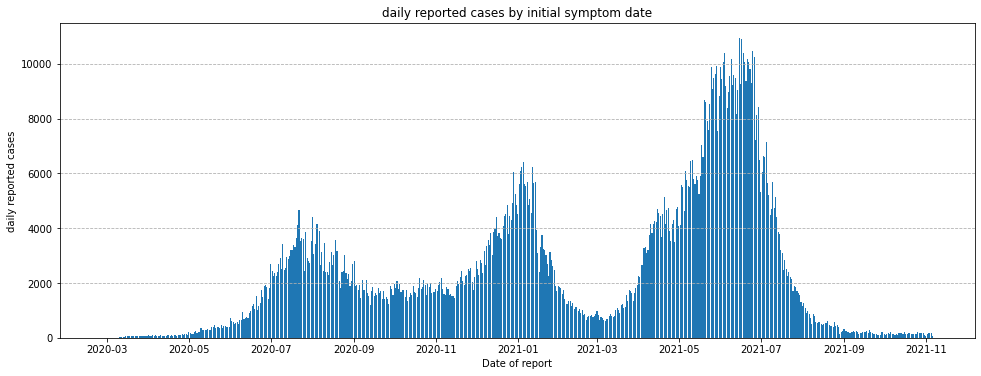

In [28]:
w = 16.4
h = 5.8
plt.figure(1, figsize=[w, h])
plt.title('daily reported cases by initial symptom date')
plt.bar(graph_1['FECHA_DE_INICIO_DE_SINTOMAS'], graph_1['CASOS_REPORTADOS'])
plt.axis('on')
plt.grid(axis='y', linestyle='--')
plt.ylabel("daily reported cases")
plt.xlabel("Date of report")
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Casos_diarios_por_fecha.png')
plt.show()

In [29]:
# Active cases by intial symptom date

#Method used to calculate active cases 
def TotalActiveCases (date):
    col = date - start
    col = int(col.days)
    total = 0
    if col >= 15:
        for i in range(len(Loc_hist_names) - 2):
            Active = sum(grid[i][col-15:col+1])
            total = total + Active
    else:
        for i in range(len(Loc_hist_names) - 2):
            Active = sum(grid[i][0:col+1])
            total = total + Active
    return total

graph_1['TOTAL_ACTIVE_CASES'] = 0
graph_1['TOTAL_ACTIVE_CASES'] = graph_1.apply(lambda row: TotalActiveCases(row['FECHA_DE_INICIO_DE_SINTOMAS']), axis=1)

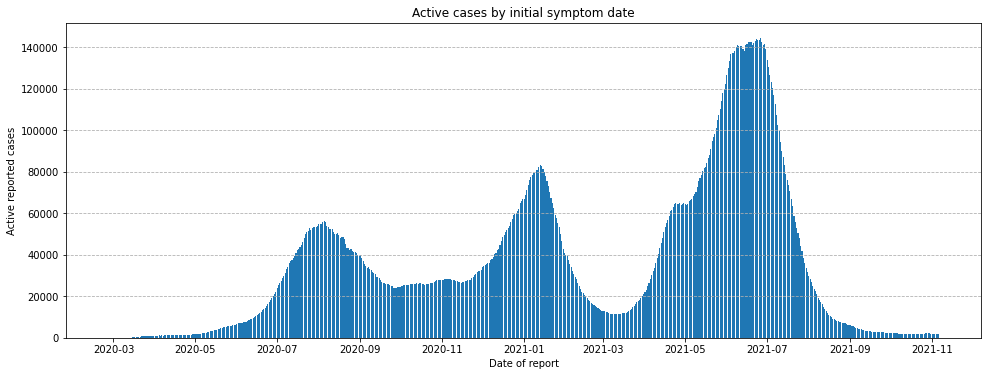

In [30]:
plt.figure(3, figsize=[w, h])
plt.title('Active cases by initial symptom date')
plt.bar(graph_1['FECHA_DE_INICIO_DE_SINTOMAS'], graph_1['TOTAL_ACTIVE_CASES'])
plt.axis('on')
plt.grid(axis='y', linestyle='--')
plt.ylabel("Active reported cases")
plt.xlabel("Date of report")
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Casos_activos_por_fecha.png')
plt.show()

In [31]:
# cumulative reported cases by intial symptom date 
graph_1['CASOS_ACUMULADOS'] = 0
anteriores = 0
def acc_count(casos): 
    global anteriores 
    acumulados = casos + anteriores
    anteriores = acumulados
    return acumulados

graph_1['CASOS_ACUMULADOS'] = graph_1.apply(lambda row: acc_count(row['CASOS_REPORTADOS']), axis=1)

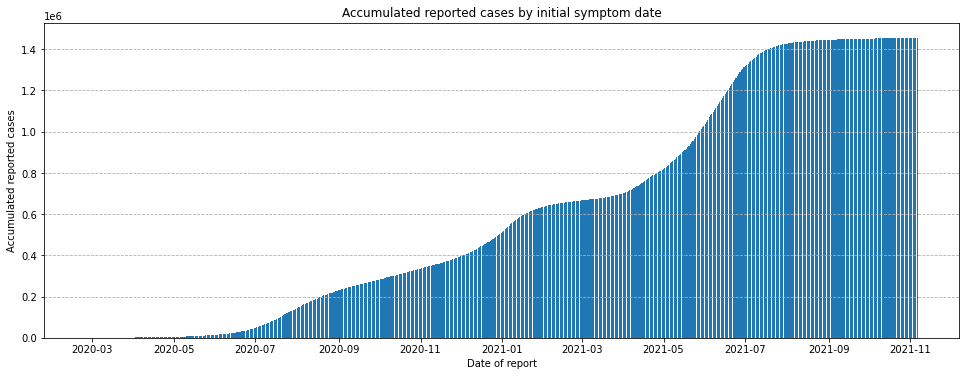

In [32]:
plt.figure(2, figsize=[w, h])
plt.title('Accumulated reported cases by initial symptom date')
plt.bar(graph_1['FECHA_DE_INICIO_DE_SINTOMAS'], graph_1['CASOS_ACUMULADOS'])
plt.axis('on')
plt.grid(axis='y', linestyle='--')
plt.ylabel("Accumulated reported cases")
plt.xlabel("Date of report")
plt.savefig('/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/Casos_acumulados_por_fecha.png')
plt.show()

In [34]:
#Save Data Frames
path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/CovidBog.pkl'
CovidBog.to_pickle(path)

path = '/home/ubuntu/javeriana/MOTUS-PUJ/Step_1/Outputs/reporte.pkl'
reporte.to_pickle(path)